In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os

In [3]:
data = pq.read_table('./data/2016_01.parquet')
df = data.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10905067 entries, 0 to 10905066
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   object        
 18  airport_fee         

In [4]:
df = df.drop_duplicates().reset_index(drop=True)
df['trip_id'] = df.index

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_id
0,1,2016-01-01 00:12:22,2016-01-01 00:29:14,1,3.2,1,N,48,262,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36,None,None,0
1,1,2016-01-01 00:41:31,2016-01-01 00:55:10,2,1.0,1,N,162,48,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,None,None,1
2,1,2016-01-01 00:53:37,2016-01-01 00:59:57,1,0.9,1,N,246,90,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30,None,None,2
3,1,2016-01-01 00:13:28,2016-01-01 00:18:07,1,0.8,1,N,170,162,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30,None,None,3
4,1,2016-01-01 00:33:04,2016-01-01 00:47:14,1,1.8,1,N,161,140,2,11.0,0.5,0.5,0.00,0.0,0.3,12.30,None,None,4


# Create dimension table

In [6]:
datetime_dim = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].reset_index(drop = True)
datetime_dim['tpep_pickup_datetime'] = datetime_dim['tpep_pickup_datetime']
datetime_dim['pick_hour'] = datetime_dim['tpep_pickup_datetime'].dt.hour
datetime_dim['pick_day'] = datetime_dim['tpep_pickup_datetime'].dt.day
datetime_dim['pick_month'] = datetime_dim['tpep_pickup_datetime'].dt.month
datetime_dim['pick_year'] = datetime_dim['tpep_pickup_datetime'].dt.year
datetime_dim['pick_weekday'] = datetime_dim['tpep_pickup_datetime'].dt.weekday

datetime_dim['tpep_dropoff_datetime'] = datetime_dim['tpep_dropoff_datetime']
datetime_dim['drop_hour'] = datetime_dim['tpep_dropoff_datetime'].dt.hour
datetime_dim['drop_day'] = datetime_dim['tpep_dropoff_datetime'].dt.day
datetime_dim['drop_month'] = datetime_dim['tpep_dropoff_datetime'].dt.month
datetime_dim['drop_year'] = datetime_dim['tpep_dropoff_datetime'].dt.year
datetime_dim['drop_weekday'] = datetime_dim['tpep_dropoff_datetime'].dt.weekday

datetime_dim['datetime_id'] = datetime_dim.index
datetime_dim = datetime_dim[['datetime_id', 'tpep_pickup_datetime', 'pick_hour', 'pick_day', 'pick_month', 'pick_year', 'pick_weekday',
                             'tpep_dropoff_datetime', 'drop_hour', 'drop_day', 'drop_month', 'drop_year', 'drop_weekday']]

datetime_dim.head()

,datetime_id,tpep_pickup_datetime,pick_hour,pick_day,pick_month,pick_year,pick_weekday,tpep_dropoff_datetime,drop_hour,drop_day,drop_month,drop_year,drop_weekday
0,0,2016-01-01 00:12:22,0,1,1,2016,4,2016-01-01 00:29:14,0,1,1,2016,4
1,1,2016-01-01 00:41:31,0,1,1,2016,4,2016-01-01 00:55:10,0,1,1,2016,4
2,2,2016-01-01 00:53:37,0,1,1,2016,4,2016-01-01 00:59:57,0,1,1,2016,4
3,3,2016-01-01 00:13:28,0,1,1,2016,4,2016-01-01 00:18:07,0,1,1,2016,4
4,4,2016-01-01 00:33:04,0,1,1,2016,4,2016-01-01 00:47:14,0,1,1,2016,4


In [7]:
passenger_count_dim = df[['passenger_count']].reset_index(drop=True)
passenger_count_dim['passenger_count_id'] = passenger_count_dim.index
passenger_count_dim = passenger_count_dim[['passenger_count_id','passenger_count']]

trip_distance_dim = df[['trip_distance']].reset_index(drop=True)
trip_distance_dim['trip_distance_id'] = trip_distance_dim.index
trip_distance_dim = trip_distance_dim[['trip_distance_id','trip_distance']]

In [8]:
rate_code_type = {
    1:"Standard rate",
    2:"JFK",
    3:"Newark",
    4:"Nassau or Westchester",
    5:"Negotiated fare",
    6:"Group ride"
}

rate_code_dim = df[['RatecodeID']].reset_index(drop=True)
rate_code_dim['rate_code_id'] = rate_code_dim.index
rate_code_dim['rate_code_name'] = rate_code_dim['RatecodeID'].map(rate_code_type)
rate_code_dim = rate_code_dim[['rate_code_id','RatecodeID','rate_code_name']]

In [9]:
payment_type_name = {
    1:"Credit card",
    2:"Cash",
    3:"No charge",
    4:"Dispute",
    5:"Unknown",
    6:"Voided trip"
}
payment_type_dim = df[['payment_type']].reset_index(drop=True)
payment_type_dim['payment_type_id'] = payment_type_dim.index
payment_type_dim['payment_type_name'] = payment_type_dim['payment_type'].map(payment_type_name)
payment_type_dim = payment_type_dim[['payment_type_id','payment_type','payment_type_name']]

In [10]:
location_lookup = pd.read_csv('./data/taxi_zone_lookup.csv')
location_lookup

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [11]:
location_dim = df[['PULocationID', 'DOLocationID']].reset_index(drop = True)
location_dim['Location_id'] = location_dim.index

In [12]:
merge_df = location_dim.merge(location_lookup, left_on='PULocationID', right_on='LocationID', how='inner')
merge_df.columns = ['PULocationID','DOLocationID','Location_id','LocationID','PU_Borough', 'PU_Zone', 'PU_service_zone']
merge_df = merge_df.merge(merge_df, left_on='DOLocationID', right_on='LocationID', how='inner')
merge_df

In [ ]:
merge_df

Error: Session cannot generate requests

In [ ]:
fact_table = df.merge(passenger_count_dim, left_on='trip_id', right_on='passenger_count_id') \
             .merge(trip_distance_dim, left_on='trip_id', right_on='trip_distance_id') \
             .merge(rate_code_dim, left_on='trip_id', right_on='rate_code_id') \
             .merge(datetime_dim, left_on='trip_id', right_on='datetime_id') \
             .merge(payment_type_dim, left_on='trip_id', right_on='payment_type_id') \
             [['trip_id','VendorID', 'datetime_id', 'passenger_count_id',
               'trip_distance_id', 'rate_code_id', 'store_and_fwd_flag',
               'payment_type_id', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
               'improvement_surcharge', 'total_amount']]

Error: Session cannot generate requests

In [ ]:
fact_table

,trip_id,VendorID,datetime_id,passenger_count_id,trip_distance_id,rate_code_id,store_and_fwd_flag,payment_type_id,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,0,1,0,0,0,0,N,0,14.50,3.0,0.5,3.65,0.0,0.3,21.95
1,1,1,1,1,1,1,N,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30
2,2,2,2,2,2,2,N,2,7.50,0.5,0.5,1.76,0.0,0.3,10.56
3,3,2,3,3,3,3,N,3,8.00,0.5,0.5,0.00,0.0,0.3,11.80
4,4,2,4,4,4,4,N,4,23.50,0.5,0.5,3.00,0.0,0.3,30.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2463926,2,2463926,2463926,2463926,2463926,None,2463926,8.00,0.0,0.5,2.39,0.0,0.3,13.69
2463927,2463927,2,2463927,2463927,2463927,2463927,None,2463927,16.80,0.0,0.5,4.35,0.0,0.3,24.45
2463928,2463928,2,2463928,2463928,2463928,2463928,None,2463928,11.22,0.0,0.5,2.00,0.0,0.3,16.52
2463929,2463929,2,2463929,2463929,2463929,2463929,None,2463929,12.40,0.0,0.5,0.00,0.0,0.3,15.70


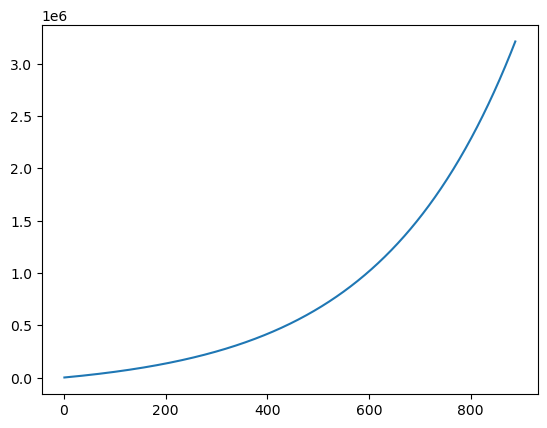

In [14]:
account = 0
income = 4500
percent = 0.1
years_working = 37
months_working = years_working*12
n_cashf = months_working*2
account += income*percent
r = 0.09
account = np.zeros(n_cashf)
account[0] = income*percent
for i in range(1, n_cashf):
    account[i] = account[i-1]*(1+r/24) + income*percent

import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1, n_cashf+1/2, 1)
plt.plot(x, account)
plt.show()

In [5]:
account = 0
for i in range(n_cashf-1):
    account += income*percent
print(account)

399150.0


In [7]:
print(r/24)

0.00375
